# AdaBoost背景

​	学习分为了强可学习和弱可学习，如果存在一个多项式的学习算法能够学习这个概率，并且准确率很高，就说这个概念是强可学习，如果准确率只是比随机猜测略好，那就是弱可学习，**如果一个概念是强可学习，那么他的充要条件就是他也是弱可学习。**

​	于是，就有一种想法提出：能否把弱可学习提升为强可学习？

​	首先用弱学习算法反复学习，得到一系列的弱分类器**，然后将多个弱分类器按照误差率小，权重大的方式线性组合成一个强分类器，并且将前一轮分类错误的数据的样本权重变大，分类正确的降低**，从而可以使得没有分类正确的样本在下一个弱分类器中更受关注，而AdaBoost就是实现上述想法，也是这个算法的一个特点。



# AdaBoost算法

​	输入：一个二分类的训练数据

​	输出：分类器$G(x)$

​	1.初始化训练数据的权重分布：
$$
D_1=(w_{11},...w_{1i}...,w_{1N}),w_{1i}=\frac{1}{N},i=1,2...N
$$
​	2.对于$m=1,2...,M$

​		a.使用有相同权重的训练数据学习，得到基本分类器（弱分类器）：
$$
G_m(x):\mathcal{X}\rightarrow\{-1,+1\}
$$
​

​		b.计算这个分类器在训练数据上的分类误差率：
$$
em=\sum_{i=1}^NP(G_m(x_i)\neq y_i)=\sum_{i=1}^Nw_{mi}I(G_m(x_i)\neq y_i)
$$


​		c.计算这个分类器的系数：
$$
\alpha_m=\frac{1}{2}ln\frac{1-e_m}{e_m}
$$
​			可以看出，$e_m<0.5$时，$\alpha_m>0$，说明分类器系数的作用是使得分类误差越小的分类器在最终分类器的		作用越大。



​		d.更新数据集的权重：
$$
D_{m+1}=(w_{m+1,1},...,w_{m+1,i},...,w_{m+1,N})\\
w_{m+1,i}=\frac{w_{mi}}{Z_m}e^{-\alpha_my_iG_m(x_i)},i=1,...,N\\
Z_M=\sum_{i=1}^Nw_{mi}e^{-\alpha_my_iG_m(x_i)}\\
$$
​			$Z_M$是一个规范化因子，这样实现了归一化的效果，并且使得$D_{m+1}$变成了一个概率分布，
$$
\begin{equation}
w_{m+1,i}=
\left\{
\begin{array}{ll}
\frac{w_{mi}}{Z_m}e^{-\alpha_m},分类正确\\
\frac{w_{mi}}{Z_m}e^{\alpha_m}，分类错误


\end{array}
\right.
\end{equation}
$$
​				从括号里的两个式子可知，如果分类错误，则样本的权重扩大，反之缩小，实现没有分类正确的			样本在下一个弱分类器中更受关注。



​	3.将基本分类器线性组合：
$$
f(x)=\sum_{m=1}^M\alpha_mG_m(x)
$$
​		最终的分类器：
$$
G(x)=sign(f(x))
$$


- 总结

  Adaboost的主要优点有：

　　　　1）Adaboost作为分类器时，分类精度很高

　　　　2）在Adaboost的框架下，可以使用各种回归分类模型来构建弱学习器，非常灵活。

　　　　3）作为简单的二元分类器时，构造简单，结果可理解。

　　　　4）一般不容易发生过拟合，但如果弱分离器个数越多，则拟合程度越好，当然也越容易过拟合。

　　Adaboost的主要缺点有：

　　　　1）**==对异常样本敏感，异常样本在迭代中可能会获得较高的权重，影响最终的强学习器的预测准确性。==**



# 使用sklearn实现AdaBoost

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

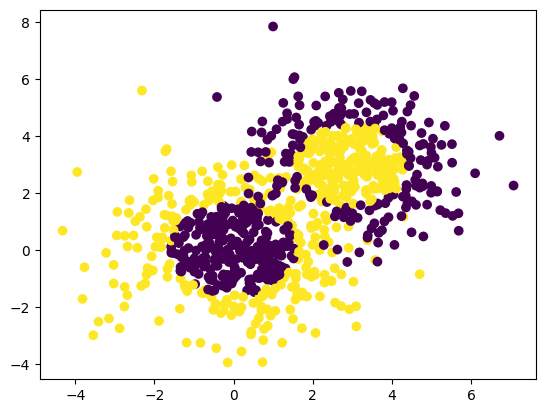

In [2]:
# 生成2维正态分布，生成的数据按分位数分为两类，500个样本,2个样本特征，协方差系数为2
X1, y1 = make_gaussian_quantiles(cov=2.0, n_samples=500, n_features=2, n_classes=2, random_state=1)
# 生成2维正态分布，生成的数据按分位数分为两类，400个样本,2个样本特征均值都为3，协方差系数为2
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=400, n_features=2, n_classes=2, random_state=1)
# 将两组数据合成一组数据
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.show()

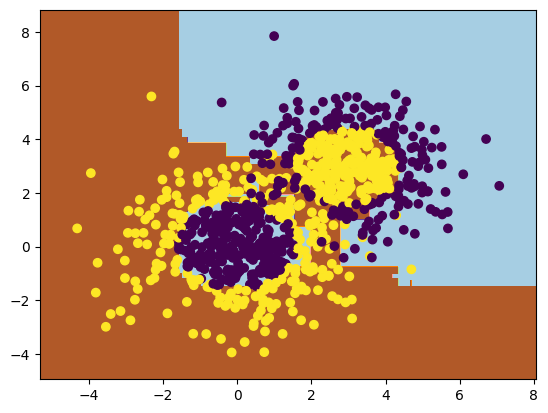

Score: 0.9133333333333333 0


In [3]:
#这里选择了SAMME算法，Scikit-Learn使用的其实是AdaBoost的一个多分类版本，叫作
#SAMME(基于多类指数损失函数的逐步添加模型)。当只有两类时， SAMME即等同于AdaBoost。最多200个弱分类器，
#步长0.8，在实际运用中可能需要通过交叉验证调参而选择最好的参数。
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20, min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=200, learning_rate=0.8)


bdt.fit(X, y)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.show()

print("Score:", bdt.score(X, y), 0)
